# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [4]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [9]:
#your turn
# join the offers and transactions table
# defaults to using the join keys which have identical column names, here offer_id!
df = pd.merge(df_offers, df_transactions)
# create a "pivot table" which will give us the number of times each customer responded to a given offer
# default aggfunc is mean() not sum(), probably better since it gives just 1s and NAs
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

# my turn
Q: What values of $SS$ do you believe represent better clusterings? Why?
A: 0 would be perfect, 0 error such as if every point was its own cluster.


In [10]:
# Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = matrix.columns[1:]
print(x_cols)

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')


4    34
2    21
0    17
3    15
1    13
Name: cluster, dtype: int64


(100, 34)

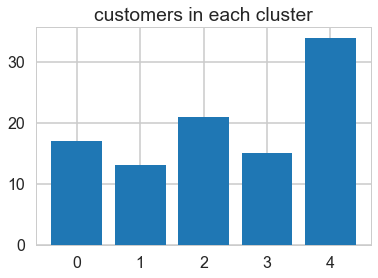

In [23]:
# Write code that applies the KMeans clustering method from scikit-learn to this matrix.
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])

cluster_counts=matrix.cluster.value_counts()
print(cluster_counts)

plt.bar(cluster_counts.index, cluster_counts)
plt.title('customers in each cluster')

# can't scatterplot a 32 dimensional space of points showing offers responded to by each customer
# 100 rows (customers) x 34 colums = cluster number, customer name, 32 offers 
matrix.shape

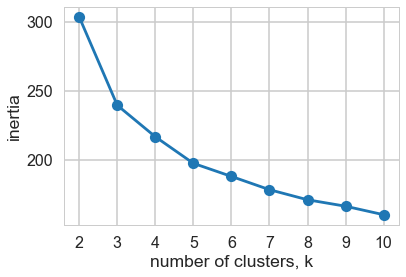

In [25]:
# Construct a plot showing SS for each K and pick K using this plot. For simplicity, test 2≤K≤10 .
ks = range(2, 11)
inertias = []
# slice matrix so we only include the 0/1 indicator columns in the clustering
samples = matrix[matrix.columns[2:]]

for k in ks:
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


4    21
5    17
6    15
3    15
2    14
1    13
0     5
dtype: int64


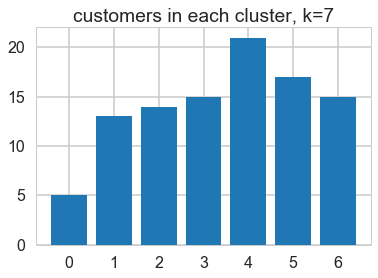

In [38]:
# Make a bar chart showing the number of points in each cluster for k-means under the best K .
best_k=7
model=KMeans(n_clusters=best_k)
    
# Use fit_predict to fit model and obtain cluster labels: labels
labels = model.fit_predict(samples)

# count values for each label
label_counts=pd.Series(labels).value_counts()

print(label_counts)
# plot bar chart
plt.bar(label_counts.index, label_counts)
plt.title('customers in each cluster, k={}'.format(best_k))
# show all labels
plt.xticks(range(best_k))
plt.show()

What challenges did you experience using the Elbow method to pick K ?

Sum-of-squares error did not slow down too much.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.3109359814688953
For n_clusters = 3 The average silhouette_score is : 0.2595691555790776
For n_clusters = 4 The average silhouette_score is : 0.24894268857448668
For n_clusters = 5 The average silhouette_score is : 0.21639432672969539
For n_clusters = 6 The average silhouette_score is : 0.20163259001211575
For n_clusters = 7 The average silhouette_score is : 0.20506038424953332
For n_clusters = 8 The average silhouette_score is : 0.20197665653774677
For n_clusters = 9 The average silhouette_score is : 0.1839218415353968
For n_clusters = 10 The average silhouette_score is : 0.15432339841653153


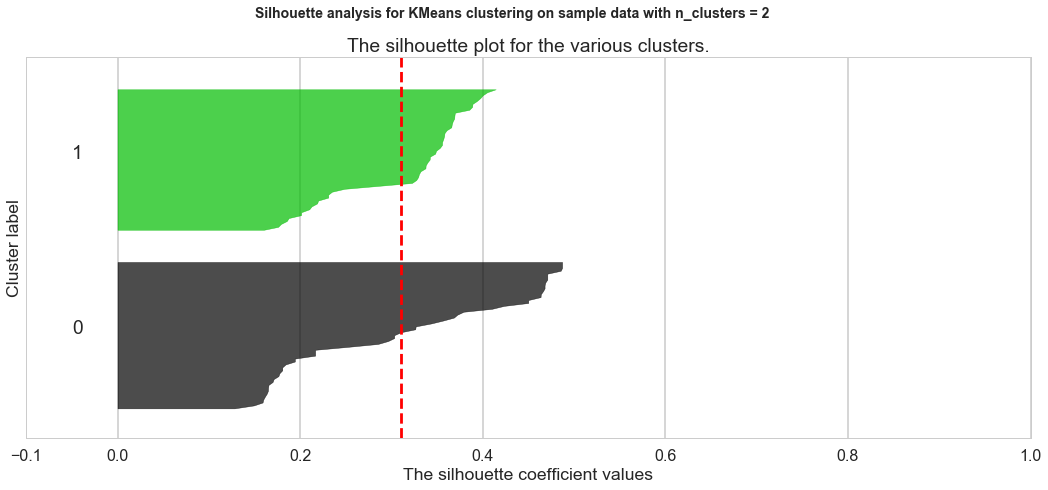

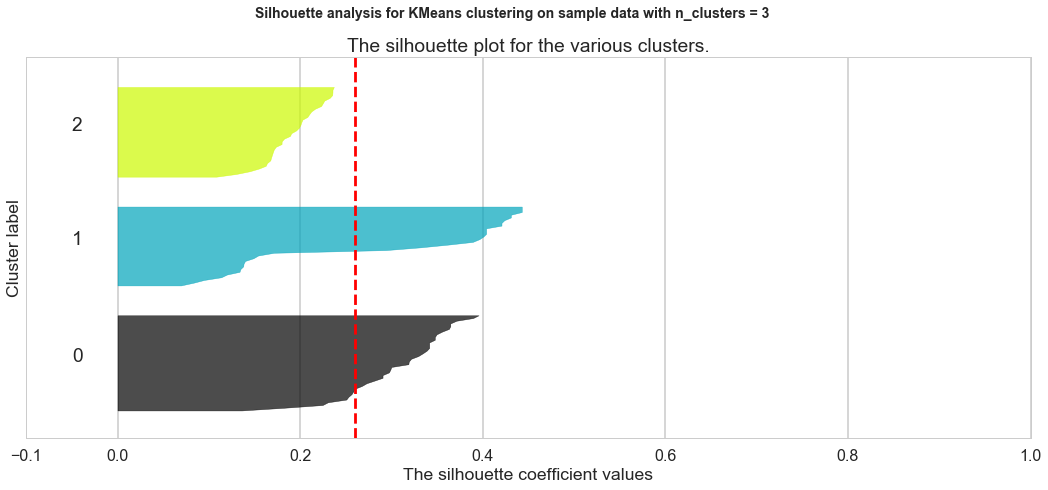

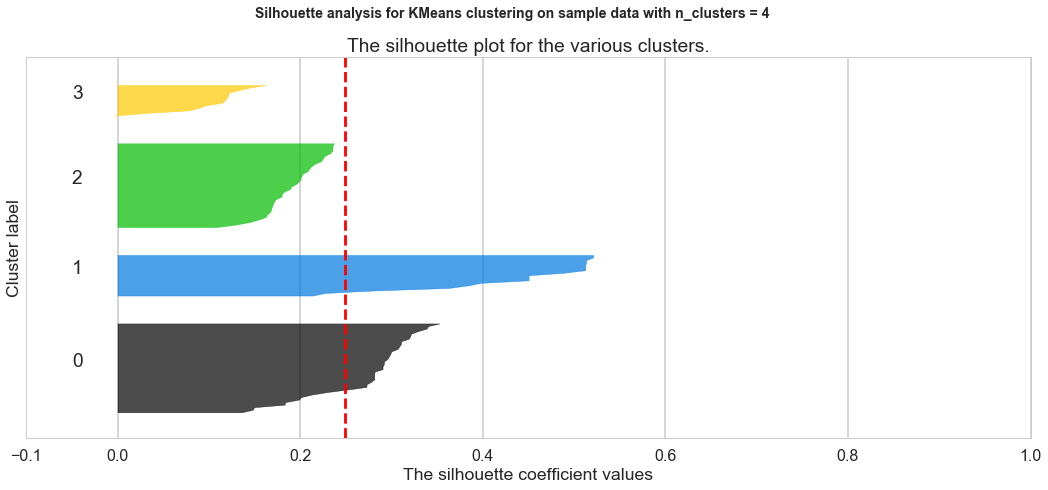

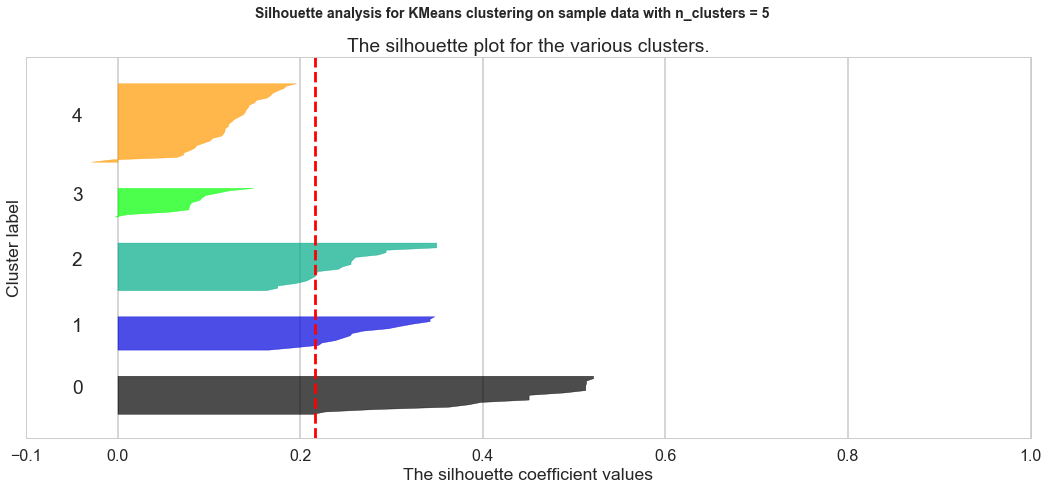

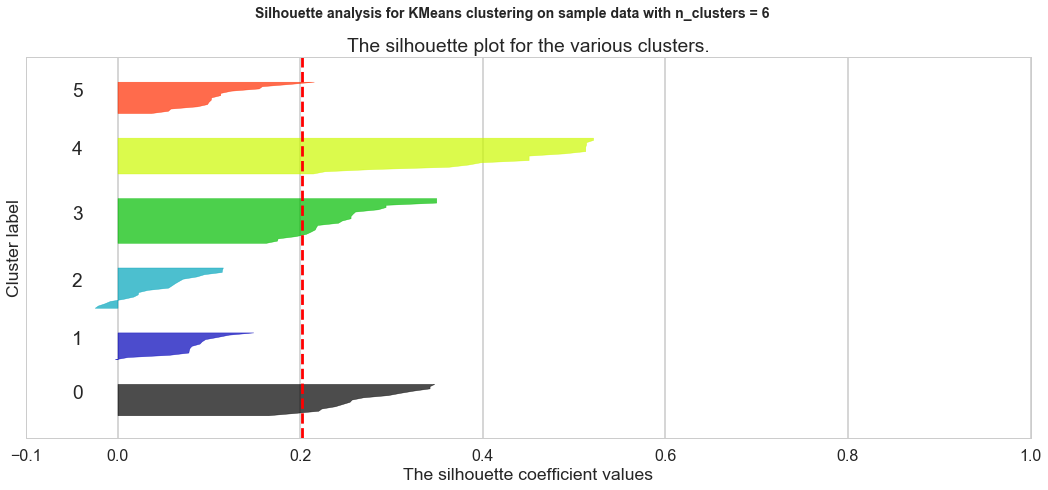

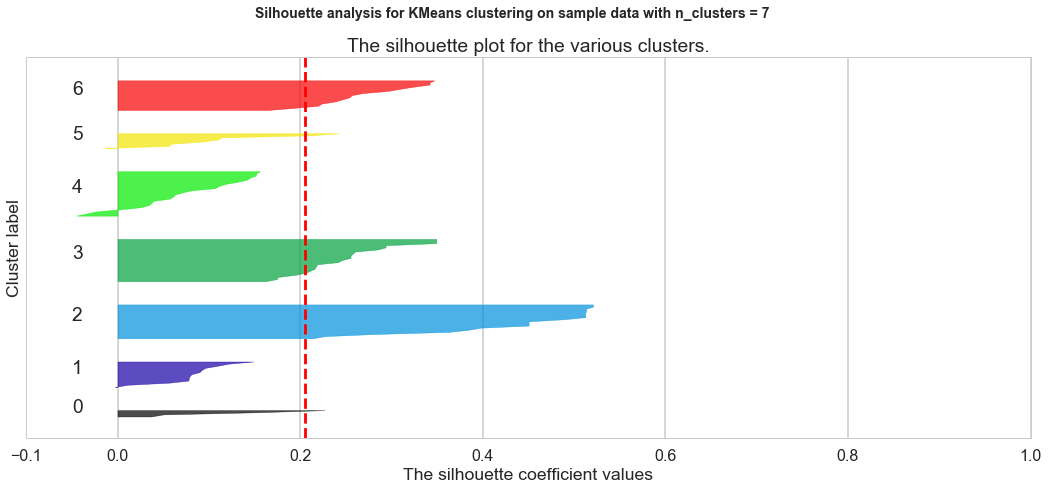

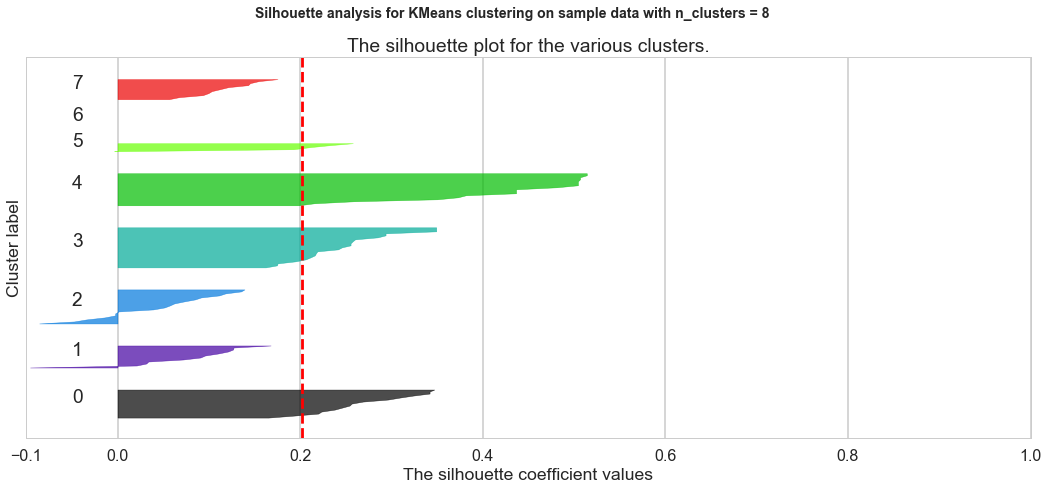

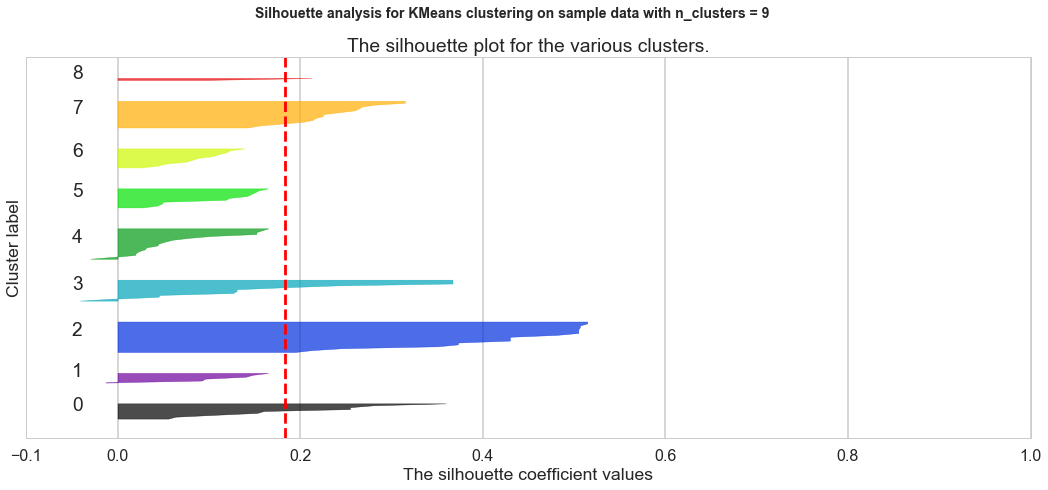

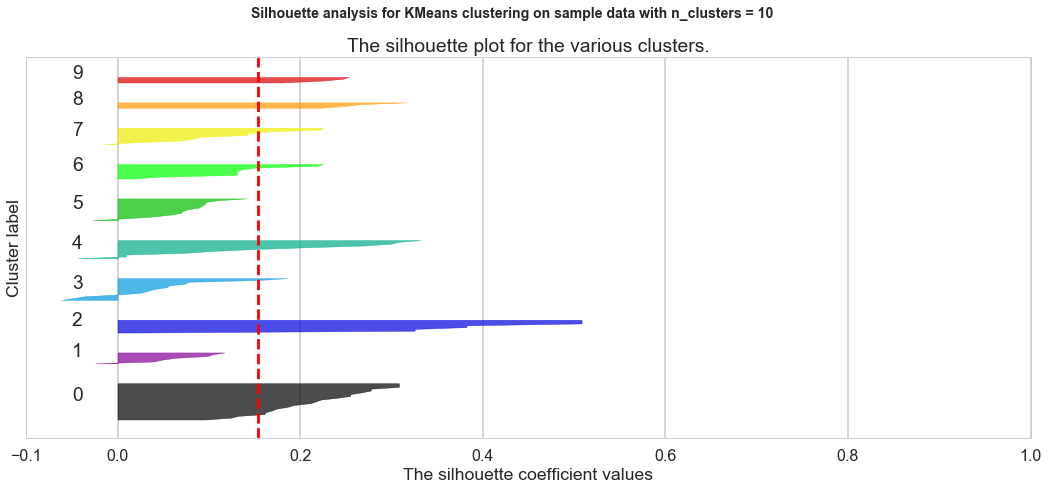

In [43]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# set data to cluster X as samples from above
X = samples
# set range to be Ks from above
range_n_clusters = ks

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


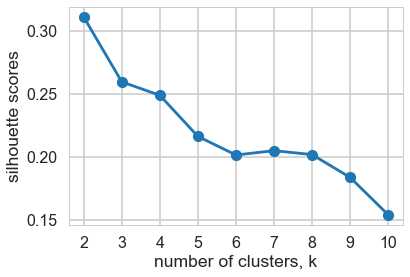

In [45]:
# compute average silhouette scores and plot them, which would I pick? 2, is weak but highest.
silhouettes = []

for k in ks:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Append the inertia to the list of inertias
    silhouettes.append(silhouette_avg)
    
# Plot ks vs inertias
plt.plot(ks, silhouettes, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette scores')
plt.xticks(ks)
plt.show()


### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

(100, 2)
(100, 4)
  customer_name  cluster         x         y
0         Adams        4  0.352179  1.030774
1         Allen        1  1.361353 -0.285819
2      Anderson        5  2.552096 -0.324987
3        Bailey        3 -0.658364  0.686688
4         Baker        6 -1.730561  0.000481


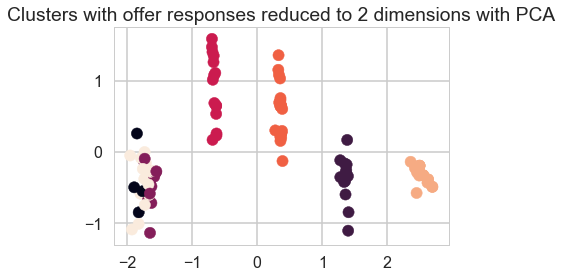

In [79]:
# my turn
# Use PCA to plot my clusters

# Import PCA
from sklearn.decomposition import PCA

# Create a PCA model with 2 components: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the 0/1 samples
pca.fit(X)

# Transform the scaled samples: pca_features
pca_features = pca.transform(X)

# Print the shape of pca_features
print(pca_features.shape)

# create a dataframe
df_pca = pd.DataFrame({'customer_name': matrix.customer_name, 'cluster': labels, 'x': pca_features[:,0], 'y':pca_features[:,1]})

print(df_pca.shape)
print(df_pca.head())

plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster'])
plt.title('Clusters with offer responses reduced to 2 dimensions with PCA')
plt.show()

(100, 2)
(100, 4)
  customer_name  cluster         x         y
0         Adams        2  0.352179  1.030774
1         Allen        1  1.361353 -0.285819
2      Anderson        0  2.552096 -0.324987
3        Bailey        3 -0.658364  0.686688
4         Baker        4 -1.730561  0.000481


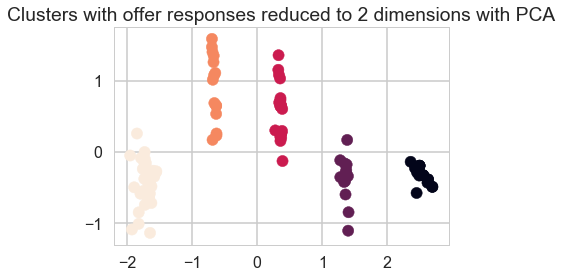

In [80]:
# NOW Use PCA to plot their 5 clusters

# Import PCA
from sklearn.decomposition import PCA

# Create a PCA model with 2 components: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the 0/1 samples
pca.fit(X)

# Transform the scaled samples: pca_features
pca_features = pca.transform(X)

# Print the shape of pca_features
print(pca_features.shape)

# create a dataframe
df_pca = pd.DataFrame({'customer_name': matrix.customer_name, 'cluster': matrix.cluster, 'x': pca_features[:,0], 'y':pca_features[:,1]})

print(df_pca.shape)
print(df_pca.head())

plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster'])
plt.title('Clusters with offer responses reduced to 2 dimensions with PCA')
plt.show()

Well it appears that 5 clusters would have been better than 7 shown here. The PCA seems to be the best way to assess the number of clusters.

In [81]:
# put together original data with customer clusters and 2 pca dimensions
df = pd.merge(df_transactions, df_pca)
df = pd.merge(df_offers, df)
print(df.head())


   offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  cluster         x         y  
0        Thomas  1        1  1.403832 -0.842461  
1       Jackson  1        4 -1.626517 -0.713410  
2      Mitchell  1        0  2.358474 -0.136183  
3      Peterson  1        0  2.449865 -0.573106  
4          Wood  1        4 -1.671339 -0.453658  


In [82]:
#explore
df['is_4'] = df.cluster==4
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Pinot Noir            41
       Espumante             30
       Prosecco              23
       Malbec                22
       Champagne             17
       Pinot Grigio          17
       Cabernet Sauvignon    16
       Merlot                12
       Chardonnay            10
True   Champagne             64
       Prosecco              20
       Cabernet Sauvignon    16
       Espumante             10
       Malbec                10
       Merlot                 8
       Chardonnay             5
       Pinot Noir             3
Name: varietal, dtype: int64

In [83]:
df.groupby("is_4").origin.value_counts()

is_4   origin      
False  France          62
       Australia       32
       Oregon          18
       South Africa    18
       Chile           17
       Italy           17
       California       9
       Germany          9
       New Zealand      6
True   France          66
       Chile           20
       Oregon           8
       Australia        7
       California       7
       Germany          7
       Italy            7
       New Zealand      7
       South Africa     7
Name: origin, dtype: int64

In [84]:
df.groupby("is_4")[['min_qty', 'discount']].mean()

,min_qty,discount
is_4,,
False,45.925532,57.622340
True,75.661765,62.051471


In [85]:
df['is_3'] = df.cluster==3
df.groupby("is_3").varietal.value_counts()

is_3   varietal          
False  Champagne             81
       Pinot Noir            44
       Cabernet Sauvignon    32
       Espumante             31
       Prosecco              26
       Malbec                24
       Merlot                16
       Chardonnay            15
       Pinot Grigio           9
True   Prosecco              17
       Espumante              9
       Malbec                 8
       Pinot Grigio           8
       Merlot                 4
Name: varietal, dtype: int64

In [86]:
df.groupby("is_3")[['min_qty', 'discount']].mean()

,min_qty,discount
is_3,,
False,66.107914,60.521583
True,11.869565,53.195652


In [87]:
df.groupby("is_3").origin.value_counts()

is_3   origin      
False  France          112
       Chile            33
       Italy            24
       Australia        23
       Oregon           21
       South Africa     21
       Germany          16
       California       15
       New Zealand      13
True   Australia        16
       France           16
       Oregon            5
       Chile             4
       South Africa      4
       California        1
Name: origin, dtype: int64

In [88]:
df['is_2'] = df.cluster==2
df.groupby("is_2").varietal.value_counts()

is_2   varietal          
False  Champagne             78
       Pinot Noir            44
       Prosecco              41
       Cabernet Sauvignon    30
       Malbec                23
       Espumante             19
       Merlot                18
       Chardonnay            15
       Pinot Grigio           9
True   Espumante             21
       Malbec                 9
       Pinot Grigio           8
       Champagne              3
       Cabernet Sauvignon     2
       Merlot                 2
       Prosecco               2
Name: varietal, dtype: int64

In [89]:
df.groupby("is_2")[['min_qty', 'discount']].mean()

,min_qty,discount
is_2,,
False,65.545126,59.758123
True,16.340426,57.851064


In [90]:
df.groupby("is_2").origin.value_counts()

is_2   origin      
False  France          109
       Australia        39
       Chile            34
       Italy            24
       Oregon           17
       Germany          16
       California       14
       South Africa     13
       New Zealand      11
True   France           19
       South Africa     12
       Oregon            9
       Chile             3
       California        2
       New Zealand       2
Name: origin, dtype: int64

In [91]:
df['is_1'] = df.cluster==1
df.groupby("is_1").varietal.value_counts()

is_1   varietal          
False  Champagne             68
       Pinot Noir            41
       Prosecco              41
       Espumante             40
       Malbec                29
       Cabernet Sauvignon    18
       Pinot Grigio          16
       Merlot                15
       Chardonnay             6
True   Cabernet Sauvignon    14
       Champagne             13
       Chardonnay             9
       Merlot                 5
       Malbec                 3
       Pinot Noir             3
       Prosecco               2
       Pinot Grigio           1
Name: varietal, dtype: int64

In [92]:
df.groupby("is_1")[['min_qty', 'discount']].mean()

,min_qty,discount
is_1,,
False,53.167883,58.09854
True,87.120000,67.06000


In [93]:
df.groupby("is_1").origin.value_counts()

is_1   origin      
False  France          110
       Australia        36
       Chile            27
       South Africa     24
       Oregon           22
       Italy            19
       Germany          14
       California       12
       New Zealand      10
True   France           18
       Chile            10
       Italy             5
       California        4
       Oregon            4
       Australia         3
       New Zealand       3
       Germany           2
       South Africa      1
Name: origin, dtype: int64

In [94]:
df['is_0'] = df.cluster==0
df.groupby("is_0").varietal.value_counts()

is_0   varietal          
False  Champagne             80
       Prosecco              41
       Espumante             40
       Cabernet Sauvignon    32
       Malbec                30
       Merlot                19
       Pinot Grigio          17
       Chardonnay            14
       Pinot Noir             6
True   Pinot Noir            38
       Malbec                 2
       Prosecco               2
       Champagne              1
       Chardonnay             1
       Merlot                 1
Name: varietal, dtype: int64

In [95]:
df.groupby("is_0")[['min_qty', 'discount']].mean()

,min_qty,discount
is_0,,
False,57.204301,60.781362
True,65.866667,51.422222


In [ ]:
df.groupby("is_0").origin.value_counts()

notes:
cluster 4: french champaign and chilean prosecco b 6 cases, little Autrailian
cluster 3: Procecco, never champaign, pinot noir or cab by the single case
cluster 2: espumante never pinot noir by 1.5 cases
cluster 1: cab and champaign like group 4 by 6 cases!
cluster 0: pinot noir club here, 5 cases

Or something else: Yes, an artificial dataset mostly on order quantity

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

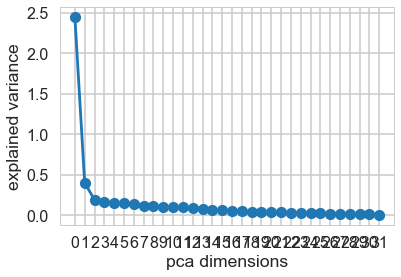

In [99]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
pca_dimensions=np.arange(len(pca.explained_variance_))
plt.plot(pca_dimensions, pca.explained_variance_, '-o')
plt.xlabel('pca dimensions')
plt.ylabel('explained variance')
plt.xticks(pca_dimensions)
plt.show()

# oh yeah, looks like 2 pca dimensions explains most of the variance

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [123]:
# My turn
# Since I thought the KMeans solution was great I'll compare to that solution

# 1. Affinity propagation
from sklearn.cluster import AffinityPropagation
ap_model=AffinityPropagation()
ap_labels = ap_model.fit_predict(samples)
print("Affinity Propogation found {} clusters".format(np.unique(ap_labels).size))
print("compare to {} clusters found by KMeans".format(np.unique(matrix.cluster).size))

from sklearn.metrics import confusion_matrix 
print(confusion_matrix(ap_labels,matrix.cluster))

from sklearn import metrics
metrics.adjusted_rand_score(ap_labels,matrix.cluster)

Affinity Propogation found 12 clusters
compare to 5 clusters found by KMeans
[[ 0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0]
 [ 7  1  0  0  0  0  0  0  0  0  0  0]]


0.46635910029956373

In [124]:
# 2. Spectral clustering
from sklearn.cluster import SpectralClustering
sc_model=SpectralClustering()
sc_labels = sc_model.fit_predict(samples)
print("Spectral clustering found {} clusters".format(np.unique(sc_labels).size))
print("compare to {} clusters found by KMeans".format(np.unique(matrix.cluster).size))

print(confusion_matrix(sc_labels,matrix.cluster))

metrics.adjusted_rand_score(sc_labels,matrix.cluster)

Spectral clustering found 8 clusters
compare to 5 clusters found by KMeans
[[14  0  0  0  0  0  0  0]
 [ 3  9  3  3 32  0  0  0]
 [ 0  0  6  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0]]


0.46508478474034376

In [127]:
# 3. Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
gc_model=AgglomerativeClustering(n_clusters=5)
gc_labels = gc_model.fit_predict(samples)
print("Spectral clustering found {} clusters".format(np.unique(gc_labels).size))
print("compare to {} clusters found by KMeans".format(np.unique(matrix.cluster).size))

print(confusion_matrix(gc_labels,matrix.cluster))

metrics.adjusted_rand_score(gc_labels,matrix.cluster)

Spectral clustering found 5 clusters
compare to 5 clusters found by KMeans
[[ 0  0  0  0 34]
 [ 0 13  0  0  0]
 [ 0  0 21  1  0]
 [17  0  0  0  0]
 [ 0  0  0 14  0]]


0.9794586083548035

In [131]:
# 4. DBSCAN
from sklearn.cluster import DBSCAN
db_model=DBSCAN(eps=0.1, min_samples=3)
db_labels = db_model.fit_predict(samples)
print("DBSCAN clustering found {} clusters".format(np.unique(db_labels).size))
print("compare to {} clusters found by KMeans".format(np.unique(matrix.cluster).size))

print(confusion_matrix(db_labels,matrix.cluster))

metrics.adjusted_rand_score(db_labels,matrix.cluster)

DBSCAN clustering found 4 clusters
compare to 5 clusters found by KMeans
[[ 0 11 13 18 15 34]
 [ 0  3  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]


0.03383406169803822

Notes: name, clusters found,adjusted rand score, comments

Affinity Propogation, 12, 0.466, 1 point different but somehow scored meh

Spectral clustering, 8, 0.465, created 1 cluster containing some of all 5, yuck

Agglomerative clustering, 5, 0.979, 1 point different - great!

DBSCAN, 1-5, near 0.0, tried a few parameters with no luck, probably does not like 1/0 matricies, bad

Agglomerative clustering is the winner!! My story: because it is simple and the distances in the clusters are vastly smaller then intra-cluster distances. This linkage based approach handles that case well.